In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

In [27]:
data = pd.read_csv("yellow_tripdata_2015-01.csv")
data.shape

(12748986, 19)

In [28]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [29]:
data.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    3
total_amount             0
dtype: int64

## 2.Pre-Processing

In [31]:
data.dropna(inplace=True)

In [32]:
# Load the data
# data = pd.read_csv('/kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-01.csv')

# Convert Y/N to 1/0
data['store_and_fwd_flag'] = LabelEncoder().fit_transform(data['store_and_fwd_flag'])

# Convert timestamp columns to datetime
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

# Extract features from timestamp columns (hour, day, month)
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['pickup_day'] = data['tpep_pickup_datetime'].dt.day
data['pickup_month'] = data['tpep_pickup_datetime'].dt.month
data['dropoff_hour'] = data['tpep_dropoff_datetime'].dt.hour
data['dropoff_day'] = data['tpep_dropoff_datetime'].dt.day
data['dropoff_month'] = data['tpep_dropoff_datetime'].dt.month

# Drop unnecessary columns
data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)

# Standardize numerical features
numerical_features = ['trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
data[numerical_features] = StandardScaler().fit_transform(data[numerical_features])

# Display the preprocessed data
data.head()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_hour,pickup_day,pickup_month,dropoff_hour,dropoff_day,dropoff_month
0,2,1,-0.001206,-0.141436,0.139331,1,0,-0.137039,0.136850,1,...,0.001262,-0.159444,0.243998,0.001755,19,15,1,19,15,1
1,1,1,-0.001032,-0.142201,0.134694,1,0,-0.139009,0.138398,1,...,0.000132,-0.159444,0.243998,0.002433,20,10,1,20,10,1
2,1,1,-0.001184,-0.138418,0.148773,1,0,-0.134735,0.150298,2,...,-0.001675,-0.159444,0.243998,-0.003894,20,10,1,20,10,1
3,1,1,-0.001316,-0.142936,0.132825,1,0,-0.140003,0.131268,2,...,-0.001675,-0.159444,0.243998,-0.009316,20,10,1,20,10,1
4,1,1,-0.001062,-0.139192,0.141539,1,0,-0.139989,0.135399,2,...,-0.001675,-0.159444,0.243998,0.001077,20,10,1,20,10,1


In [6]:
data.payment_type.value_counts()

1    7881388
2    4816992
3      38632
4      11972
5          2
Name: payment_type, dtype: int64

## Determine No of Clusters

In [7]:
data.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'pickup_hour', 'pickup_day',
       'pickup_month', 'dropoff_hour', 'dropoff_day', 'dropoff_month'],
      dtype='object')

In [8]:
data.shape

(12748986, 23)

In [33]:
# Select all features for clustering
features_for_clustering = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                               'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 
                               'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'pickup_hour', 'pickup_day',
       'pickup_month', 'dropoff_hour', 'dropoff_day', 'dropoff_month']
len(features_for_clustering)

19

In [11]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# Deciding no of clusters upon 10Lakhs Sample
X = data[features_for_clustering].sample(100000)

# Assuming 'data' is your pre-processed DataFrame
n_samples = len(X)
n_clusters_range = range(2, 11)  # Number of clusters range from 2 to 10

# Specify the number of chunks
n_chunks = 10
chunk_size = n_samples // n_chunks

# Placeholder for silhouette scores
silhouette_scores = []
inertia = []

# Loop through different cluster numbers
for n_clusters in n_clusters_range:
    # Initialize MiniBatchKMeans
    mbkmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, n_init='auto', batch_size=chunk_size)
    
    # Loop through chunks
    for i in range(0,len(X),chunk_size):
        
        # Extract the chunk
        chunked_data = X[i:i+chunk_size]
        
        # Partially fit the model on the chunk
        mbkmeans.partial_fit(chunked_data)
    
    # For remaining chunk
    if len(X) % chunk_size != 0:
        chunk_remaining = X[-(len(X) % chunk_size):]

        mbkmeans.partial_fit(chunk_remaining)


    # Predict clusters for all data points
    labels = mbkmeans.predict(X)
    
    # Inertia
    inertia.append(mbkmeans.inertia_)
    # Calculate silhouette score
    silhouette = silhouette_score(X, labels)
    silhouette_scores.append(silhouette)
    print(f"Training for No of Clusters- {n_clusters} completed!!")

Training for No of Clusters- 2 completed!!
Training for No of Clusters- 3 completed!!
Training for No of Clusters- 4 completed!!
Training for No of Clusters- 5 completed!!
Training for No of Clusters- 6 completed!!
Training for No of Clusters- 7 completed!!
Training for No of Clusters- 8 completed!!
Training for No of Clusters- 9 completed!!
Training for No of Clusters- 10 completed!!


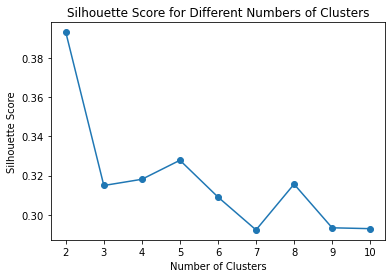

In [12]:
import matplotlib.pyplot as plt

# Plot the silhouette scores
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

* As per silhouette, No of Clusters = 2

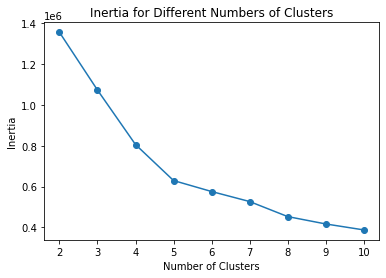

In [13]:
# Plot inertia vs No Of centroids
plt.plot(n_clusters_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia for Different Numbers of Clusters')
plt.show()

* As per Elbow method no of cluster: 5

In [14]:
inertia

[1356997.0956211693,
 1073648.172909503,
 806299.447416535,
 629848.5543910859,
 576066.5652248835,
 526952.5511846147,
 453211.4643678996,
 417022.35708960483,
 387825.0102062338]

In [15]:
silhouette_scores

[0.39326217215895876,
 0.3149392427193177,
 0.31811401019970087,
 0.3278405990554825,
 0.30904396810688606,
 0.29223757224458796,
 0.3156355799634736,
 0.2933232475791645,
 0.2928785542685472]

In [34]:
import time
# Taking optimal no of clusters as 5

start = time.time()
X = data[features_for_clustering]

n_samples = len(X)

# Specify the number of chunks
n_chunks = 10
chunk_size = n_samples // n_chunks

# Initialize MiniBatchKMeans
mbkmeans = MiniBatchKMeans(n_clusters=5, random_state=42, n_init='auto', batch_size=chunk_size)

# Loop through chunks
for i in range(n_chunks):
    # Determine start and end index for the chunk
    for i in range(0,n_samples,chunk_size):
        
        # Extract the chunk
        chunked_data = X[i:i+chunk_size]
        
        # Partially fit the model on the chunk
        mbkmeans.partial_fit(chunked_data)
    
    # For remaining chunk
    if len(X) % chunk_size != 0:
        chunk_remaining = X[-(len(X) % chunk_size):]

        mbkmeans.partial_fit(chunk_remaining)


# Predict clusters for all data points
data['labels'] = mbkmeans.predict(X)

end= time.time() 
print('Time-Taken:', end - start)

Time-Taken: 32.09390664100647


In [35]:
data['labels'].value_counts()

0    3278062
2    2952249
4    2404194
1    2070182
3    2044296
Name: labels, dtype: int64

In [36]:
from sklearn.cluster import KMeans

X = data[features_for_clustering]

start = time.time()

kmeans = KMeans(n_init = 10, n_clusters = 5)
kmeans.fit(X)

# Predict clusters for all data points
data['labels'] = mbkmeans.predict(X)

end= time.time() 
print('Time-Taken:', end - start)

Time taken: 74.66544842720032
